### Time Series Analysis

[comment]: <> (copied shamelessly from [analytics vidya](https://courses.analyticsvidhya.com/courses/take/creating-time-series-forecast-using-python/texts/6132947-introduction-to-the-course))

#### Structure:
1. Understanding Time Series
2. Data Exploration
3. Time Series Forecasting using different methods

#### Introduction to Time Series:

Time Series data is data that is collected over time and is dependent on it. As a more formal definition, *A series of data points collected in time order is known as a time series*. Most of business houses work on time series data to analyze sales number for the next year, website traffic, count of traffic, number of calls received, etc. Data of a time series can be used for forecasting. Some examples are:
1. Stock Price
2. Passenger Count of an airlines
3. Temperature over time
4. Number of visitors in a hotel

#### Components of a Time Series:

1. **Trend**:  Trend is a general direction  in which something is developing or changing. In the below time series, we can see that the passenger count is increasing with the number of years:
![alt text](./images/1549344821475.jpg)

Here the red line represents an increasing trend of the time series.

2. **Seasonality**: Another clear pattern can also be seen in the above time series. i.e., the pattern is repeating at a regular time interval which is known as the seasaonality. Any predictable change or pattern in a time series that recurs or repeats over a specific time period can be said to be seasonality. Below is an example:
![alt text](https://s3.amazonaws.com/thinkific/file_uploads/118220/images/115/9ee/826/1549344821557.jpg)

We can see that the time series is repeating it's pattern after every 12 months i.e. there is a peak every year during the month of January and a trough every year in the month of September, hence this time series has a seasonality of 12 months. 

**Difference between a time series and Regression Problem:**<br>

A time series problem is different from a regression problem in following ways:
* The main difference is that a time series is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn't hold in this case.
* Along with an increasing of decreasing trend, most Time Series have some form of seasonality trends, i.e. variations specific to a particular frame.

So, predicting a time series using regression technique is not a good approach.<br>

Time Series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. Time series forecasting is the use of a model to predict future values based on previously observed values.

#### Problem Statement:

Unicorn Investors wants to make an investment in a new form of transportation-JetRail. JetRail uses Jet propulsion technoloty to run rails and move people at a high speed. The investment would only make sense if they can get more than 1 Million monthly users with in next 18 months. In order to hekp Unicorn Ventures in their decisio, we need to forecast the traffic on JetRail for the next 7 months. Traffic data of JetRail since inception is provided in the test file [here](https://datahack.analyticsvidhya.com/contest/practice-problem-time-series-2/).<br>

It is advised to look at the dataset after completing the hypothesis generation part.<br>

To solve the problem, we will follow below steps:

**Table of Contents:**<br>

1. **Understanding Data:**
    1. Hypothesis Generation
    2. Getting the system ready and loading the data
    3. Dataset Structure and Content
    4. Feature Extraction
    5. Exploratory Analysis <br><br>
2. **Forecasting Using Multiple Modeling Techniques:**
    1. Splitting the data into training and validation part
    2. Modeling techniques
    3. Holt's Linear Trend Model on daily time series
    4. Holt Winter's Model on daily time series
    5. Introduction to ARIMA model
    6. Parameter tuning for ARIMA model
    7. SARIMAX model on daily time series
    
Hypothesis Generation is the process of listing out all the possible factors that can affect the outcome. Hypothesis generation is done before having a look at the data in order to avoid any bias that might result aftere observation.<br><br>

1. **Hypothesis Generation:**<br>
Hypothesis Generation helps to point out the factors which might affect out dependent variable. Below are some of the hypothesis which could affect the passenger count(dependent variable for this time series problem) on the JetRail:
    1. *There will be an increase in the traffic as the years pass by.*<br>
    **Explanation-** Population has a general upward trend with time. So we can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.
    2. *The traffic will be high from May to October.*<br>
    **Explanation-** Tourists visit generally increases during this time period.
    3. *Traffic on Weekdays will be more as compared to weekends/holidays.*<br>
    **Explanation-** People will go to office on weekdays and hence the traffic will be more.
    4. *Traffic during peak hours will be high.*<br>
    **Explanation-** People will travel to work, college.<br>
    
    We will try to validate each of these hypothesis based on the dataset. Now let's have a look at the dataset.<br><br>
    
2. **Getting the system ready and loading data:**<br>
Versions:
    * Python = 3.5
    * Pandas = 0.22.0
    * scikit-learn==0.19.0
    
    

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
import warnings
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from math import sqrt 
%matplotlib inline
warnings.filterwarnings("ignore")

In [42]:
# read test and train data
train = pd.read_csv('./data/time_series/Train.csv')
test = pd.read_csv('./data/time_series/Test.csv')

In [43]:
# make copies of dataset
train_original = train.copy()
test_original = test.copy()

**3. Dataset Structure and Content:**<br>

In [44]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

We have ID, Datetime and corresponding count of passengers in the train file. For test file we have ID and Datetime only so we have to predict the Count for test file.<br>

Let’s understand each feature first:

* ID is the unique number given to each observation point.
* Datetime is the time of each observation.
* Count is the passenger count corresponding to each Datetime.

Let’s look at the data types of each feature.

In [45]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

* ID and Count are in integer format while the Datetime is in object format for the train file.
* Id is in integer and Datetime is in object format for test file.

In [46]:
train.shape, test.shape

((18288, 3), (5112, 2))

**4. Feature Extraction:**<br>
We will extract the time and date from the Datetime. We have seen earlier that the data type of Datetime is object. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [47]:
train['Datetime'] = pd.to_datetime(train['Datetime'], format='%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test['Datetime'], format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original['Datetime'], format='%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original['Datetime'], format='%d-%m-%Y %H:%M')

We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

In [48]:
for i in (train, test, train_original, test_original):
    i['year'] = i['Datetime'].dt.year
    i['month'] = i['Datetime'].dt.month
    i['day'] = i['Datetime'].dt.day
    i['hour'] = i['Datetime'].dt.hour

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic. 
* We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.

* Values of 5 and 6 represents that the days are weekend

In [49]:
train['day_of_week'] = train['Datetime'].dt.dayofweek

# Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.
train['weekend'] = train['day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)

In [50]:
# indexing Datetime to get time on x axis
train.set_index('Datetime', drop=True, inplace=True)

# dropping Id variable
df = train.drop('ID', axis=1)

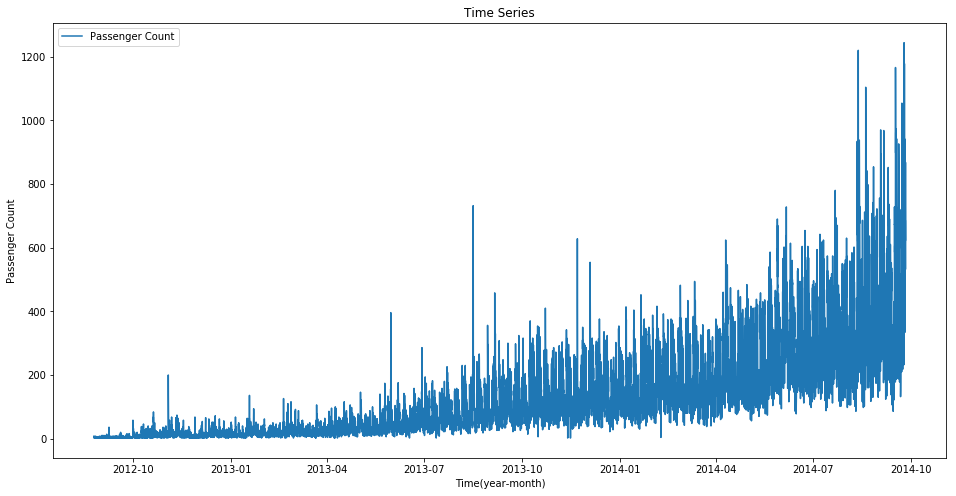

In [51]:
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger Count')
plt.legend(loc='best')

Here we can infer that there is an increasing trend in the series, i.e., the number of count is increasing with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.

We will work on the train file for all the analysis and will use the test file for forecasting.

**5. Exploratory Data Analysis: **<br>

Let's  recall the hypothesis that we made earlier:
+ Traffic will increase as the years pass by
+ Traffic will be high from May to October
+ Traffic on weekdays will be more
+ Traffic during the peak hours will be high
    
After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the dataset.

Our first hypothesis was traffic will increase as the years pass by. So let’s look at yearly passenger count.

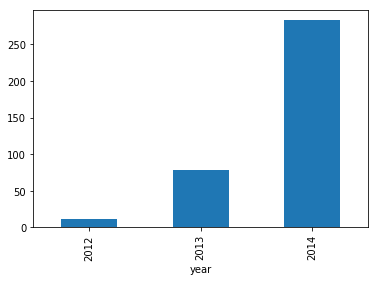

In [52]:
train.groupby('year')['Count'].mean().plot.bar()

We see an exponential growth in the traffic with respect to year which validates our hypothesis.

Our second hypothesis was about increase in traffic from May to October. So, let’s see the relation between count and month.

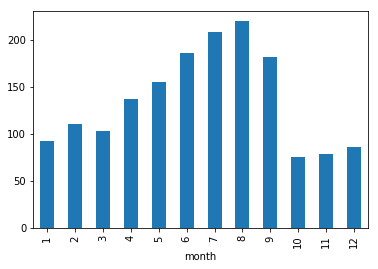

In [53]:
train.groupby('month')['Count'].mean().plot.bar()

Here we see a decrease in the mean of passenger count in last three months. This does not look right. Let’s look at the monthly mean of each year separately.

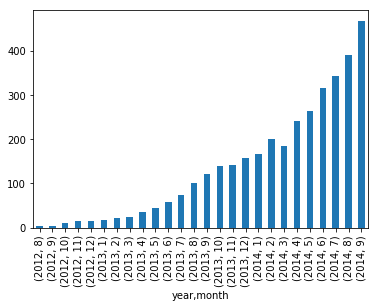

In [54]:
train.groupby(['year', 'month'])['Count'].mean().plot.bar()

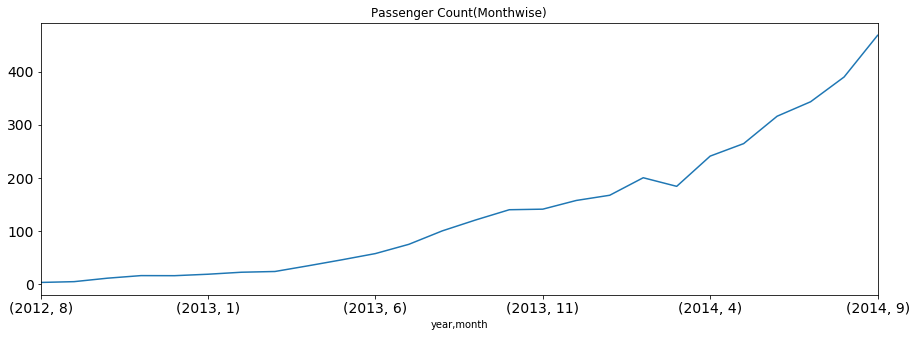

In [55]:
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

* We see that the months 10, 11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.

* Since there is an increasing trend in our time series, the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.

* In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

Let’s look at the daily mean of passenger count.

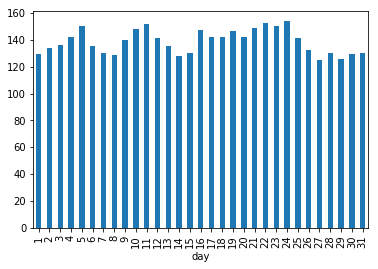

In [56]:
train.groupby('day')['Count'].mean().plot.bar()

We are not getting much insights from day wise count of the passengers.

We also made a hypothesis that the traffic will be more during peak hours. So let’s see the mean of hourly passenger count.

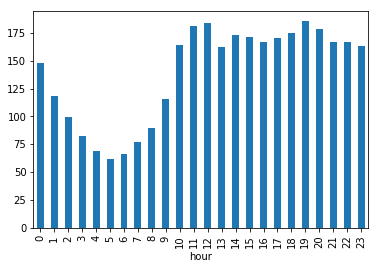

In [57]:
train.groupby('hour')['Count'].mean().plot.bar()

* It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.
* After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

Let’s try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.

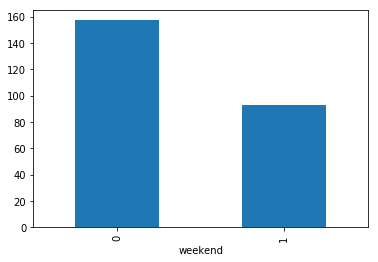

In [58]:
train.groupby('weekend')['Count'].mean().plot.bar()

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis.

Now we will try to look at the day wise passenger count.

Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

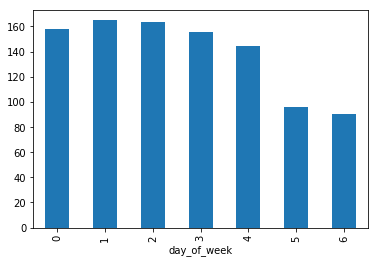

In [59]:
train.groupby('day_of_week')['Count'].mean().plot.bar()

From the above bar plot, we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week. Now we will look at basic modeling techniques. Before that we will drop the ID variable as it has nothing to do with the passenger count.

In [60]:
train.drop('ID', inplace=True, axis=1)

As we have seen that there is a lot of noise in the hourly time series, we will aggregate the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [61]:
# hourly time series
hourly = train.resample('H').mean()

# daily mean
daily = train.resample('D').mean()

# weekly meana
weekly = train.resample('W').mean()

# monthly mean
monthly = train.resample('M').mean()

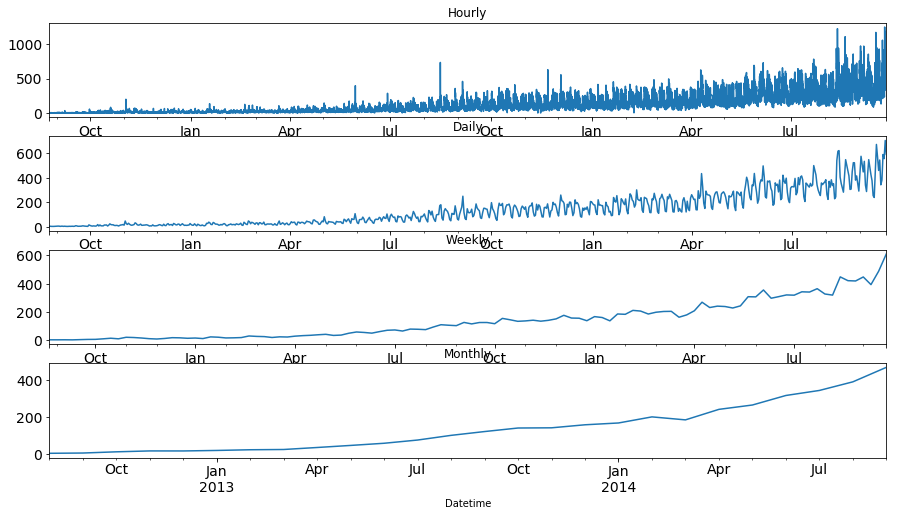

In [62]:
fig, axs = plt.subplots(4,1) 
hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

But it would be difficult to convert the monthly and weekly predictions to hourly predictions, as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So, we will work on the daily time series.

In [63]:
test.set_index('Datetime', inplace=True, drop=True)

# convert to daily meana
test = test.resample('D').mean()

#### Splitting the data into training and validation part:

Before we go ahead and build models for our dataset, we need a validation dataset to check the performance and generalisation ability of our model. Below are some of the properties of the dataset required for the purpose.

* The dataset should have the true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.
* The model should not be trained on the validation dataset. Hence, we cannot train the model on the train dataset and validate on it as well.

We generally divide the train dataset into two parts. One part is used to train the model and the other part is used as the validation dataset. There are multiple ways to divide the train dataset such as Random Division etc.

For this course, We will be using a time based split explained below.

1. **Splitting data into training and validation part:**

    we will divide our data in train and validation. We will make a model on the train part and predict on the validation part to check the accuracy of our predictions.

    NOTE - It is always a good practice to create a validation set that can be used to assess our models locally. If the validation metric(rmse) is changing in proportion to public leaderboard score, this would imply that we have chosen a stable validation technique.

    To divide the data into training and validation set, we will take last 3 months as the validation data and rest for training data. We will take only 3 months as the trend will be the most in them. If we take more than 3 months for the validation set, our training set will have less data points as the total duration is of 25 months. So, it will be a good choice to take 3 months for validation set.

    The starting date of the dataset is 25-08-2012 as we have seen in the exploration part and the end date is 25-09-2014.


In [64]:
train, v_train = train.ix['2012-08-25':'2014-06-24'], train.ix['2014-06-25':'2014-09-25']

* We have done time based validation here by selecting the last 3 months for the validation data and rest in the train data. If we would have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.

* If we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time related problems.

Now we will look at how the train and validation part has been divided.

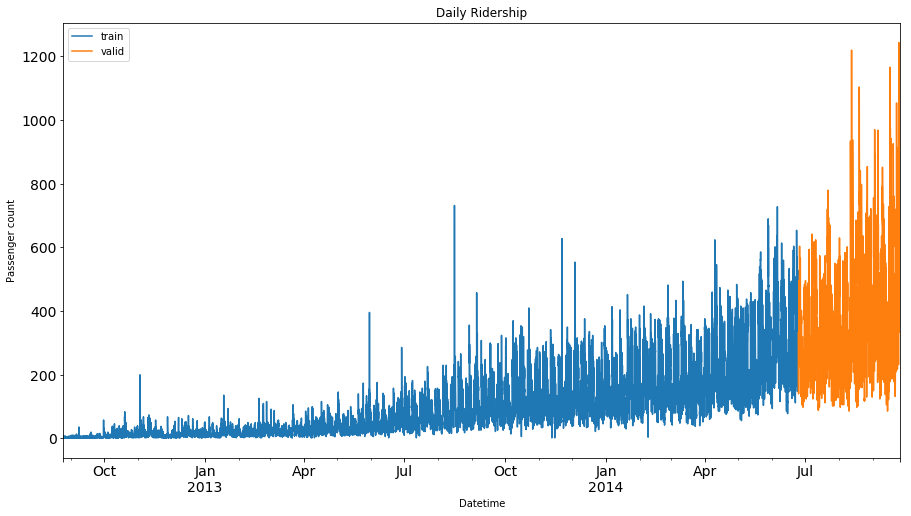

In [68]:
#train.set_index('Datetime', drop=True, inplace=True)
#v_train.set_index('Datetime', drop=True, inplace=True)
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
v_train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

Here the blue part represents the train data and the orange part represents the validation data.

We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.

We will try below methods:
1. Naive Approach
2. Moving Average
3. Simple Exponential Smoothing
4. Holt's Liner Trend Model

#### 1. Naive Approach: 

In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction.

For example, Suppose we have passenger count for 5 days and we have to predict the passenger count for next 2 days. Naive approach will assign the 5th day’s passenger count to the 6th and 7th day, i.e., 15 will be assigned to the 6th and 7th day. Below is graphical representation.
![naive approach](https://s3.amazonaws.com/thinkific/file_uploads/118220/images/cae/fd5/157/1549364621006.jpg)

The blue line is the prediction here. All the predictions are equal to the last observed point.

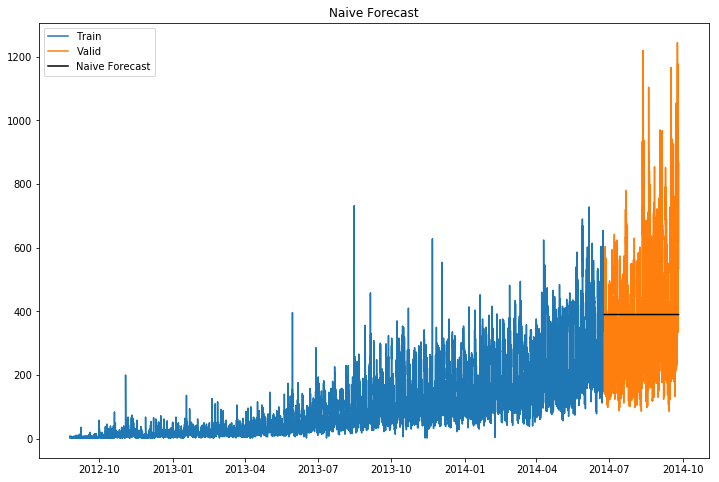

In [69]:
# forecast using  naive approach
dd = np.asarray(train['Count'])
y_hat = v_train.copy()
y_hat['naive'] = dd[len(dd)-1]

# plot the results
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(v_train.index, v_train['Count'], label='Valid')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast', color='black')
plt.legend(loc='best')
plt.title('Naive Forecast')
plt.show()

* We can calculate how accurate our predictions are using rmse(Root Mean Square Error).
* rmse is the standard deviation of the residuals.
* Residuals are a measure of how far from the regression line data points are.
* The formula for rmse is:

rmse = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left ( y_{i}-\hat{y} \right )^{2}}$

We will now calculate RMSE to check the accuracy of our model on validation data set.

In [70]:
rms = sqrt(mean_squared_error(v_train.Count, y_hat.naive))
rms

186.37368520699056

#### 2. Moving Average:

In this technique we will take the average of the passenger counts for last few time periods only. Lets try the rolling mean for last 10, 20, 50 days and visualize the results.

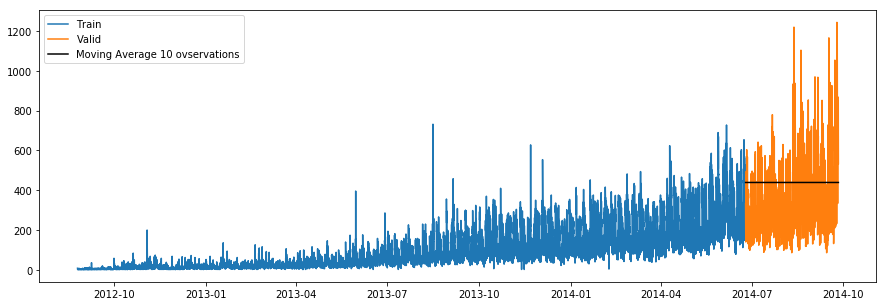

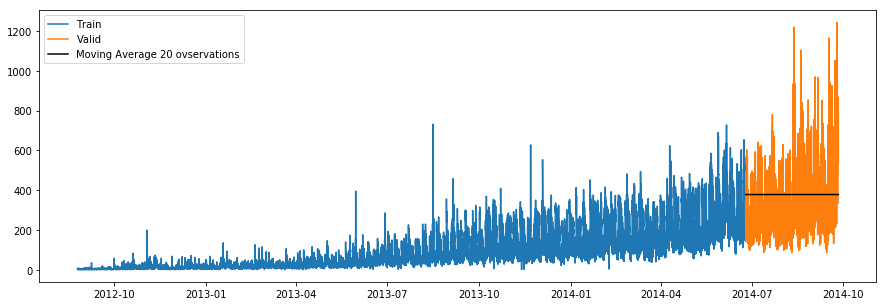

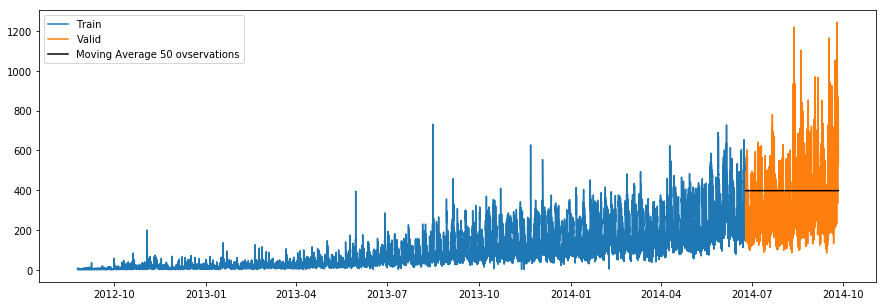

In [71]:
y_hat_avg = v_train.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(train['Count'], label='Train')
plt.plot(v_train['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average 10 ovservations', color='black')
plt.legend(loc='best')
plt.show()

y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(20).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(train['Count'], label='Train')
plt.plot(v_train['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average 20 ovservations', color='black')
plt.legend(loc='best')
plt.show()

y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(50).mean().iloc[-1]
plt.figure(figsize=(15,5))
plt.plot(train['Count'], label='Train')
plt.plot(v_train['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average 50 ovservations', color='black')
plt.legend(loc='best')
plt.show()

We can see that the predictions are getting weaker as we increase the number of observations. 

In [72]:
rms = sqrt(mean_squared_error(v_train['Count'], y_hat_avg['moving_avg_forecast'])) 
rms

186.5773761711873

#### 3. Simple Exponential Smoothing

* In this technique, we assign larger weights to more recent observations than to observations from the distant past.
* The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

**NOTE -** If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value.

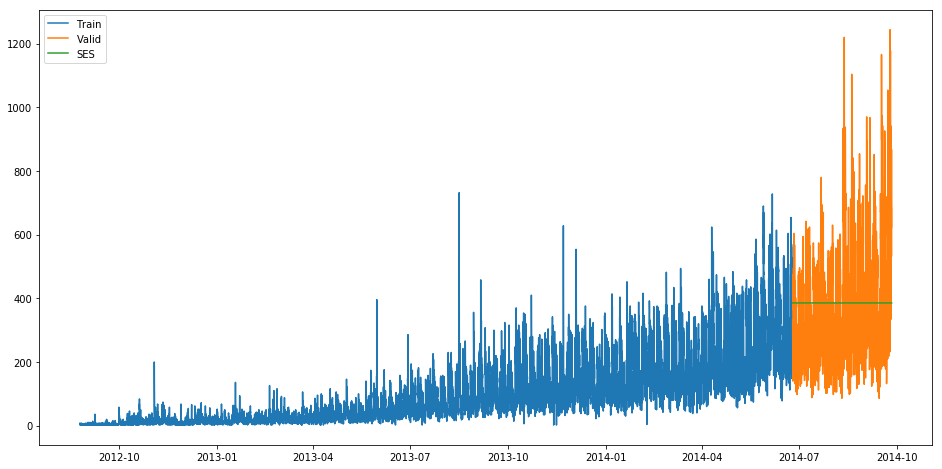

In [74]:
y_hat_avg = v_train.copy()
fit2 = SimpleExpSmoothing(np.array(train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(v_train))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(v_train['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [75]:
rms = sqrt(mean_squared_error(v_train['Count'], y_hat_avg['SES']))
rms

186.40944652452376

#### 4.  Holt’s Linear Trend Model

* It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
* This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.

We can decompose the time series in four parts.

* Observed, which is the original time series.
* Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
* Seasonal, which tells us about the seasonality in the time series.
* Residual, which is obtained by removing any trend or seasonality in the time series.

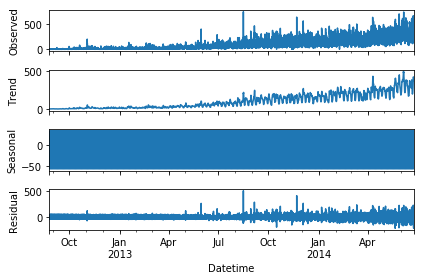

In [78]:
sm.tsa.seasonal_decompose(train['Count']).plot() 
result = sm.tsa.stattools.adfuller(train['Count'])
plt.show()

An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

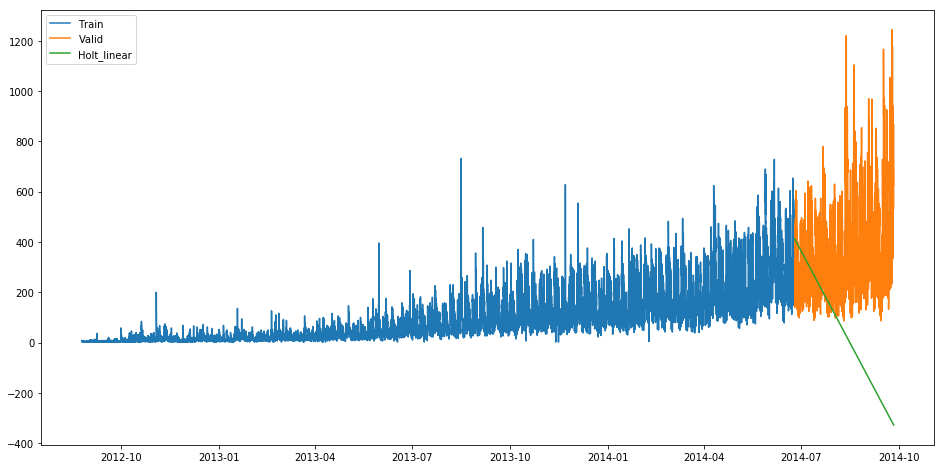

In [83]:
y_hat_avg = v_train.copy() 
fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(v_train)) 
plt.figure(figsize=(16,8)) 
plt.plot(train['Count'], label='Train') 
plt.plot(v_train['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()

In [84]:
rms = sqrt(mean_squared_error(v_train['Count'], y_hat_avg['Holt_linear'])) 
rms

475.09398202897876

#### Holt’s Linear Trend Model on daily time series:

* Now let’s try to make holt’s linear trend model on the daily time series and make predictions on the test dataset.
* We will make predictions based on the daily time series and then will distribute that daily prediction to hourly predictions.
* We have fitted the holt’s linear trend model on the train dataset and validated it using validation dataset.

In [86]:
submission = pd.read_csv('./data/time_series/Sample_Submission.csv')

In [87]:
predict=fit1.forecast(len(test))

In [88]:
test['prediction'] = predict

This is the daily predictions. We have to convert these predictions to hourly basis. To do so we will first calculate the ratio of passenger count for each hour of every day. Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [89]:
# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

In [95]:
# Grouping the hourly ratio 
temp=train_original.groupby(['hour'])['ratio'].sum() 

# Groupby to csv format 
pd.DataFrame(temp, columns=['hour','ratio']).to_csv('./data/time_series//GROUPby.csv') 

In [97]:
temp2=pd.read_csv("./data/time_series/GROUPby.csv") 
temp2=temp2.drop('hour.1',1)

In [99]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['hour']=merge['hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','hour_x','hour_y'], axis=1) 
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='hour', how='left') 


In [100]:
# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24 
prediction['ID']=prediction['ID_y']

In [103]:
submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','hour', 'ratio'],axis=1) 
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('./data/time_series/Holt linear.csv', index=False)

# rmse on leaderboard: 279.6

#### Holt winter’s model on daily time series

* Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

* The above mentioned models don’t take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future prices.

* One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.


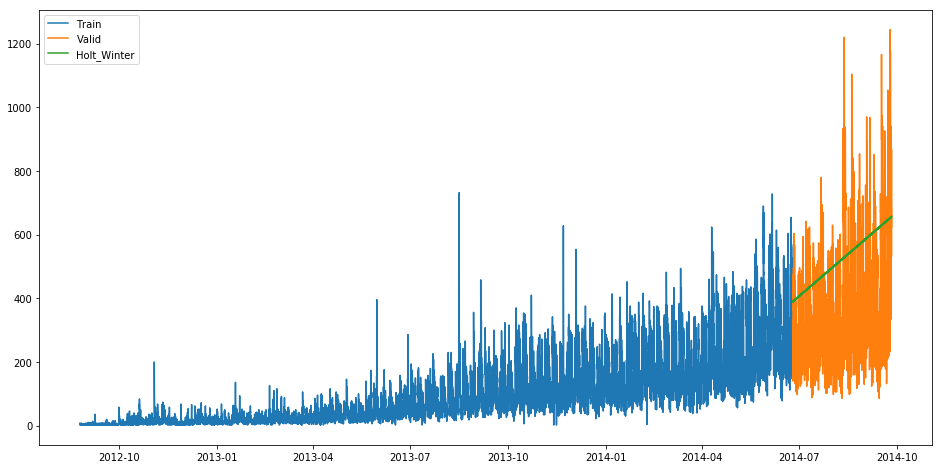

In [104]:
y_hat_avg = v_train.copy() 
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(v_train)) 
plt.figure(figsize=(16,8)) 
plt.plot( train['Count'], label='Train') 
plt.plot(v_train['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()

In [105]:
rms = sqrt(mean_squared_error(v_train['Count'], y_hat_avg['Holt_Winter']))
rms

222.71226066389136

In [106]:
predict=fit1.forecast(len(test))

In [108]:
test['prediction']=predict
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['hour']=merge['hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','hour_x','hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='hour', how='left') 

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [109]:
prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

In [111]:
# Converting the final submission to csv format 
pd.DataFrame(submission, columns=['ID','Count']).to_csv('./data/time_series/Holt winters.csv', index=False)
# leaderboard: 289.3